In [1]:
import sys
import os
sys.path.append(os.path.abspath('..'))

import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from src.config import Config
from src.model import get_model, get_poison_detector
from src.poison_detector import PoisonDetector
from src.data_loader import get_dataloaders
from src.adversarial_attacks import AdversarialAttacks
from tqdm import tqdm

# Set Plot Style
sns.set(style="whitegrid")
device = Config.DEVICE
print(f"Using device: {device}")

# Fix Dataset Path for Notebook Context
Config.DATASET_PATH = os.path.join('..', 'chest_xray')

Using device: cuda


In [2]:
print("Loading Test Data...")
test_loader, _ = get_dataloaders(Config.DATASET_PATH)
classes = ["NORMAL", "PNEUMONIA"]
print(f"Test batches: {len(test_loader)}")

Loading Test Data...
Test batches: 20


In [3]:
print("Loading Models...")

# 1. Global Classification Model
model = get_model(pretrained=False)
model_path = "../global_model_final.pth"
if os.path.exists(model_path):
    model.load_state_dict(torch.load(model_path, map_location=device))
    print("✓ Global Model loaded from 'global_model_final.pth'")
else:
    print(f"⚠️ {model_path} not found. Using random weights (metrics will be bad).")
model.eval()

# 2. Poison Detector (Autoencoder)
detector = PoisonDetector(model)
detector_path = "../poison_detector.pth"
if os.path.exists(detector_path):
    detector.load_detector(detector_path)
    print(f"✓ Poison Detector loaded. Threshold: {detector.threshold:.4f}")
else:
    print(f"⚠️ {detector_path} not found.")


Loading Models...
✓ Global Model loaded from 'global_model_final.pth'
✓ Autoencoder chargé (Seuil CORRIGÉ: 0.043900)
✓ Poison Detector loaded. Threshold: 0.0439


# 1. Classification Model Evaluation
We will evaluate the EfficientNet-V2 model on the test set.

In [4]:
y_true = []
y_pred = []
y_probs = []

print("Running Inference on Test Set...")
with torch.no_grad():
    for images, labels in tqdm(test_loader):
        images = images.to(device)
        outputs = model(images)
        probs = torch.softmax(outputs, dim=1)
        _, preds = torch.max(outputs, 1)
        
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())
        y_probs.extend(probs[:, 1].cpu().numpy())

print("Inference Complete.")

Running Inference on Test Set...


100%|██████████| 20/20 [00:12<00:00,  1.57it/s]

Inference Complete.


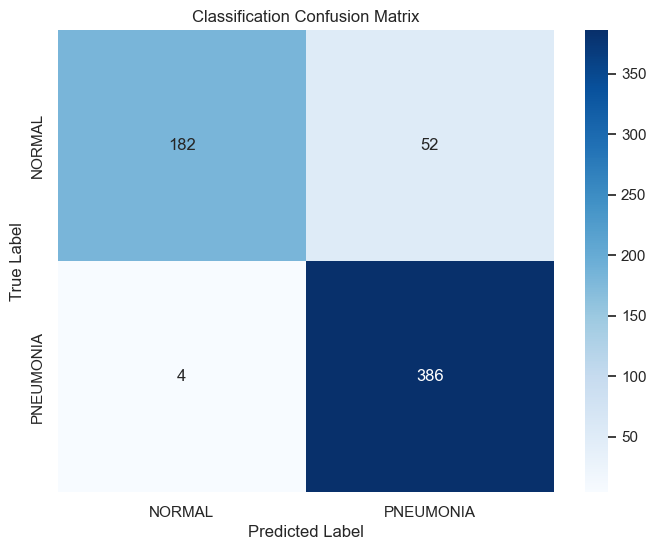

              precision    recall  f1-score   support

      NORMAL       0.98      0.78      0.87       234
   PNEUMONIA       0.88      0.99      0.93       390

    accuracy                           0.91       624
   macro avg       0.93      0.88      0.90       624
weighted avg       0.92      0.91      0.91       624



In [5]:
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.title('Classification Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

print(classification_report(y_true, y_pred, target_names=classes))

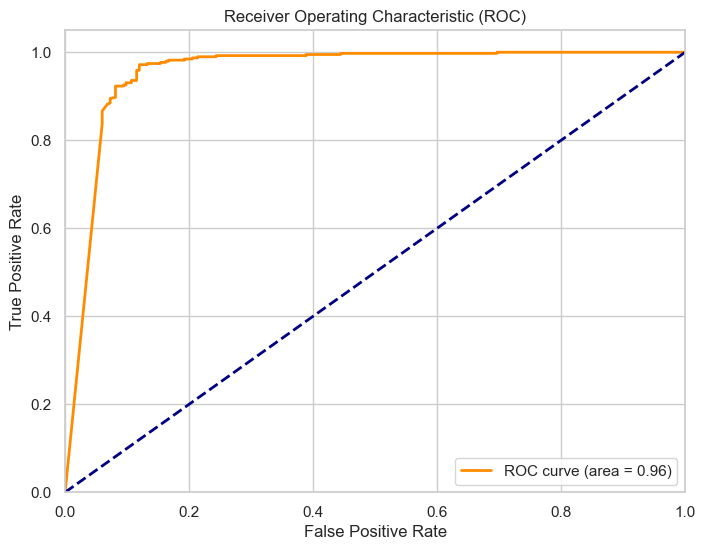

In [6]:
fpr, tpr, _ = roc_curve(y_true, y_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

# 2. Poison Detector (Autoencoder) Evaluation
We will evaluate how well the Autoencoder separates 'Clean' images from 'Adversarial' images based on reconstruction error (MSE).

In [7]:
print("Generating adversarial attacks for comparison...")

# FULL DATA EVALUATION
clean_errors = []
adv_errors = []

# Helper to extract reconstruction error
def get_errors(img_tensor):
    with torch.no_grad():
        # detect_poison returns (is_poisoned_bool, error_tensor)
        _, errors = detector.detect_poison(img_tensor)
        return errors.cpu().numpy()

print(f"Processing {len(test_loader)} batches (Full Test Set)...")
for i, (images, labels) in enumerate(tqdm(test_loader)):
    
    images = images.to(device)
    labels = labels.to(device)
    
    # 1. Clean Errors
    batch_clean_err = get_errors(images)
    clean_errors.extend(batch_clean_err)
    
    # 2. Generate Attacks (PGD)
    # We need gradients for attack generation, so enable grad momentarily for input
    model.eval() # Keep model structure fixed, but we need backward for input
    # STRONG ATTACK (Epsilon 0.15)
    adv_images = AdversarialAttacks.pgd_attack(model, images, labels, epsilon=0.15)
    
    # 3. Adversarial Errors
    batch_adv_err = get_errors(adv_images)
    adv_errors.extend(batch_adv_err)
    
print(f"Collected {len(clean_errors)} clean samples and {len(adv_errors)} adversarial samples.")

Generating adversarial attacks for comparison...
Processing 20 batches (Full Test Set)...


100%|██████████| 20/20 [01:15<00:00,  3.78s/it]

Collected 624 clean samples and 624 adversarial samples.


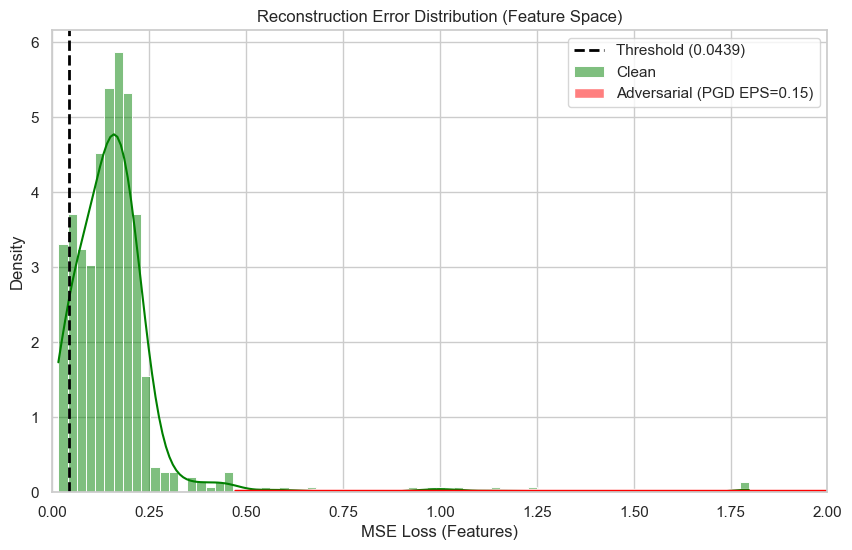

In [8]:
plt.figure(figsize=(10, 6))
sns.histplot(clean_errors, color='green', label='Clean', kde=True, stat="density", alpha=0.5)
sns.histplot(adv_errors, color='red', label='Adversarial (PGD EPS=0.15)', kde=True, stat="density", alpha=0.5)

# Plot Threshold
plt.axvline(detector.threshold, color='black', linestyle='--', linewidth=2, label=f'Threshold ({detector.threshold:.4f})')
plt.xlim(0, 2.0)
plt.title('Reconstruction Error Distribution (Feature Space)')
plt.xlabel('MSE Loss (Features)')
plt.ylabel('Density')
plt.legend()
plt.show()

In [9]:
clean_arr = np.array(clean_errors)
adv_arr = np.array(adv_errors)

# True Negatives (Clean correctly identified as Clean -> Error < Threshold)
tn = np.sum(clean_arr < detector.threshold)
fp = np.sum(clean_arr >= detector.threshold) # False Alarm

# True Positives (Attack correctly identified as Poison -> Error > Threshold)
tp = np.sum(adv_arr >= detector.threshold)
fn = np.sum(adv_arr < detector.threshold) # Missed Attack

print(f"Detector Performance (Dynamic Threshold {detector.threshold:.4f}):")
print(f"- Accuracy on Clean Data: {tn/len(clean_arr)*100:.2f}%")
print(f"- Accuracy on Attack Data: {tp/len(adv_arr)*100:.2f}%")
print(f"- False Positive Rate: {fp/len(clean_arr)*100:.2f}%")

Detector Performance (Dynamic Threshold 0.0439):
- Accuracy on Clean Data: 10.74%
- Accuracy on Attack Data: 100.00%
- False Positive Rate: 89.26%
